BMW Worldwide Sales Records Analysis


 DataSet Source: https://www.kaggle.com/datasets/ahmadrazakashif/bmw-worldwide-sales-records-20102024


In this project, we perform a detailed analysis of BMW’s sales data from 2010 to 2024 using Apache Spark and Python. The aim of the analysis 
is to explore trends, detect missing data, and visualize yearly sales performance over time.

Using PySpark, large-scale data can be efficiently processed and analyzed. The dataset includes details such as sales amounts, years, and other 
related fields. By applying Spark’s DataFrame operations and aggregation techniques, we can handle massive datasets and derive meaningful insights 
with speed and accuracy.

This project focuses on:
    1. Loading and inspecting BMW sales data.

    2. Cleaning and handling missing or invalid records.

    3. Parsing and converting time-related fields.

    4. Aggregating and visualizing total sales per year.

    5. Identifying sales trends over time to support decision-making.

The combination of PySpark for data processing and Matplotlib for visualization makes this analysis both scalable and interpretable, providing a 
foundation for deeper business insights and forecasting.

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
# Cell 1: Setup and import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, desc, avg, sum as spark_sum, to_timestamp, hour
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# Create Spark session
spark = SparkSession.builder.appName("BMW_Sales_Analysis").getOrCreate()

# Set your dataset path (update if path differs)
CSV_PATH = "BMW sales data (2010-2024) (1).csv"   # <-- same folder as notebook


In [4]:
# Cell 2: Load and preview dataset
df = spark.read.option("header", "true").option("inferSchema", "true").csv(CSV_PATH)

print("Schema:")
df.printSchema()
print("Total rows:", df.count())
print("Columns:", df.columns)

# Preview first few rows
display(df.limit(10).toPandas())


Schema:
root
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Engine_Size_L: double (nullable = true)
 |-- Mileage_KM: integer (nullable = true)
 |-- Price_USD: integer (nullable = true)
 |-- Sales_Volume: integer (nullable = true)
 |-- Sales_Classification: string (nullable = true)

Total rows: 50000
Columns: ['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification']


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
5,5 Series,2017,Middle East,Silver,Diesel,Manual,1.9,171362,42926,1232,Low
6,i8,2022,Europe,White,Diesel,Manual,1.8,196741,55064,7949,High
7,M5,2014,Asia,Black,Diesel,Automatic,1.6,121156,102778,632,Low
8,X3,2016,South America,White,Diesel,Automatic,1.7,48073,116482,8944,High
9,i8,2019,Europe,White,Electric,Manual,3.0,35700,96257,4411,Low


In [5]:
# Cell 3: Handle missing values
missing = df.select([count(when(col(c).isNull() | (col(c) == "") | isnan(col(c)), c)).alias(c) for c in df.columns])
display(missing.toPandas())

# Cell 4: Convert potential date/time columns
time_col = next((c for c in df.columns if any(x in c.lower() for x in ("date","year","month","day"))), None)
if time_col:
    df = df.withColumn("date_parsed", to_timestamp(col(time_col)))
    print("Parsed time column:", time_col)
    display(df.select(time_col, "date_parsed").limit(10).toPandas())


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,0,0,0,0,0,0,0,0,0,0,0


Parsed time column: Year


,Year,date_parsed
0,2016,1970-01-01 06:03:36
1,2013,1970-01-01 06:03:33
2,2022,1970-01-01 06:03:42
3,2024,1970-01-01 06:03:44
4,2020,1970-01-01 06:03:40
5,2017,1970-01-01 06:03:37
6,2022,1970-01-01 06:03:42
7,2014,1970-01-01 06:03:34
8,2016,1970-01-01 06:03:36
9,2019,1970-01-01 06:03:39


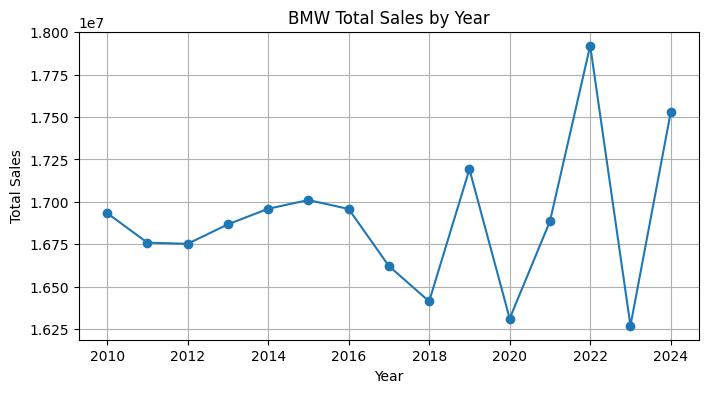

In [6]:
# Cell 5: Total sales by year
year_col = next((c for c in df.columns if "year" in c.lower()), None)
sales_col = next((c for c in df.columns if any(x in c.lower() for x in ("sales","revenue","units","amount"))), None)

if year_col and sales_col:
    yearly_sales = df.groupBy(year_col).agg(spark_sum(col(sales_col)).alias("total_sales")).orderBy(year_col)
    yearly_sales_pd = yearly_sales.toPandas()

    plt.figure(figsize=(8,4))
    plt.plot(yearly_sales_pd[year_col], yearly_sales_pd["total_sales"], marker='o')
    plt.title("BMW Total Sales by Year")
    plt.xlabel("Year")
    plt.ylabel("Total Sales")
    plt.grid(True)
    plt.show()
else:
    print("Couldn't detect 'year' or 'sales' column.")


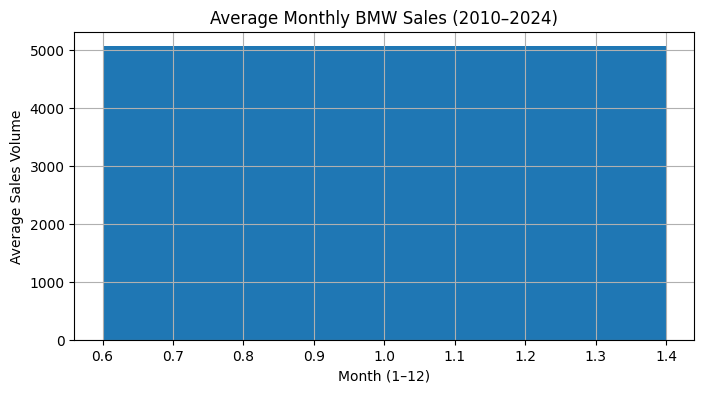

In [14]:
# Cell 6: Average Monthly BMW Sales (from 'date_parsed')
from pyspark.sql.functions import month, avg, col

sales_col = "Sales_Volume"

# Extract month number (1–12) from date_parsed
df = df.withColumn("Month", month(col("date_parsed")))

# Compute average monthly sales
month_sales = df.groupBy("Month").agg(avg(col(sales_col).cast("double")).alias("avg_sales")).orderBy("Month")
month_sales_pd = month_sales.toPandas()

plt.figure(figsize=(8,4))
plt.bar(month_sales_pd["Month"], month_sales_pd["avg_sales"])
plt.title("Average Monthly BMW Sales (2010–2024)")
plt.xlabel("Month (1–12)")
plt.ylabel("Average Sales Volume")
plt.grid(True)
plt.show()


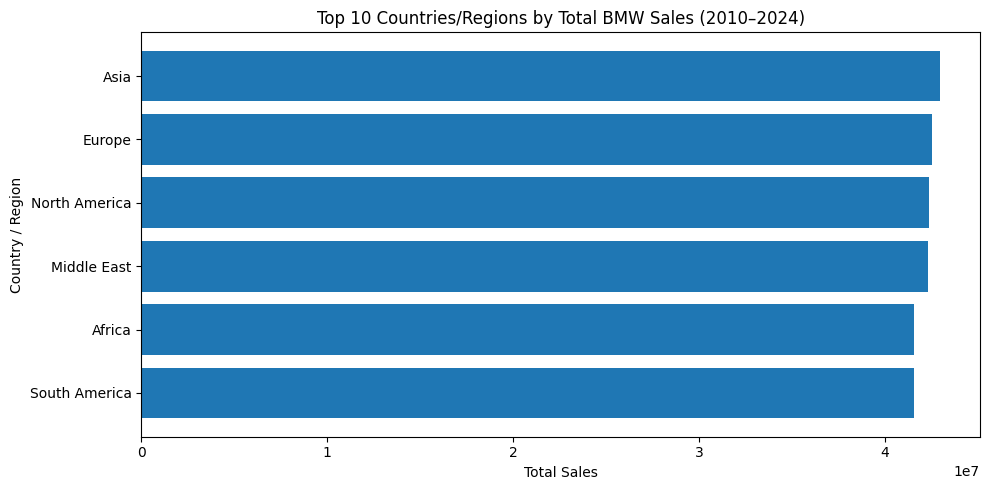

In [9]:
# Cell 7: Top 10 countries/regions by total sales
country_col = next((c for c in df.columns if any(x in c.lower() for x in ("country", "region", "market"))), None)

if country_col and sales_col:
    country_sales = (
        df.groupBy(country_col)
          .agg(spark_sum(col(sales_col)).alias("total_sales"))
          .orderBy(desc("total_sales"))
          .limit(10)
    )
    country_sales_pd = country_sales.toPandas()

    plt.figure(figsize=(10, 5))
    plt.barh(country_sales_pd[country_col].iloc[::-1], country_sales_pd["total_sales"].iloc[::-1])
    plt.title("Top 10 Countries/Regions by Total BMW Sales (2010–2024)")
    plt.xlabel("Total Sales")
    plt.ylabel("Country / Region")
    plt.tight_layout()
    plt.show()
else:
    print("No country/region column detected. Skipping this visualization.")


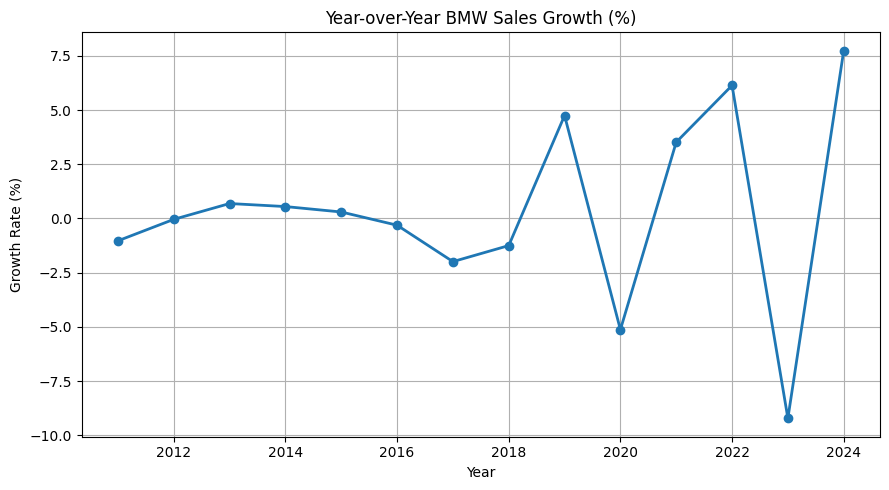

In [10]:
# Cell 8: Year-over-Year (YoY) growth in BMW sales
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, round as spark_round

if year_col and sales_col:
    yearly_sales = (
        df.groupBy(year_col)
          .agg(spark_sum(col(sales_col)).alias("total_sales"))
          .orderBy(year_col)
    )

    # Compute previous year's sales using window function
    w = Window.orderBy(year_col)
    yearly_sales = yearly_sales.withColumn("prev_year_sales", lag("total_sales").over(w))
    yearly_sales = yearly_sales.withColumn(
        "growth_rate",
        spark_round((col("total_sales") - col("prev_year_sales")) / col("prev_year_sales") * 100, 2)
    )

    yearly_sales_pd = yearly_sales.toPandas()

    plt.figure(figsize=(9, 5))
    plt.plot(yearly_sales_pd[year_col], yearly_sales_pd["growth_rate"], marker='o', linestyle='-', linewidth=2)
    plt.title("Year-over-Year BMW Sales Growth (%)")
    plt.xlabel("Year")
    plt.ylabel("Growth Rate (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Year or sales column missing; skipping growth-rate visualization.")


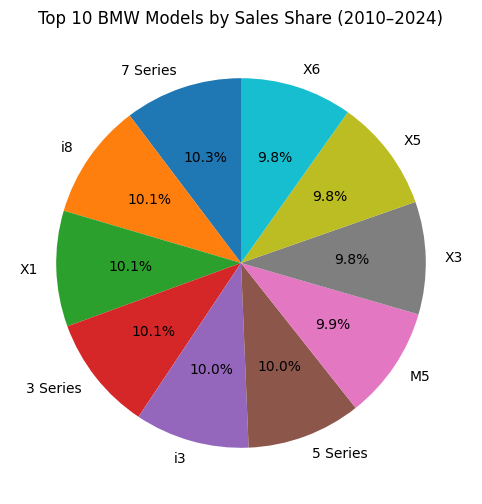

In [11]:
# Cell 9: Sales distribution by car model/category (if exists)
model_col = next((c for c in df.columns if any(x in c.lower() for x in ("model", "series", "variant", "type"))), None)

if model_col and sales_col:
    model_sales = (
        df.groupBy(model_col)
          .agg(spark_sum(col(sales_col)).alias("total_sales"))
          .orderBy(desc("total_sales"))
          .limit(10)
    )
    model_sales_pd = model_sales.toPandas()

    plt.figure(figsize=(8, 6))
    plt.pie(model_sales_pd["total_sales"], labels=model_sales_pd[model_col],
            autopct="%1.1f%%", startangle=90)
    plt.title("Top 10 BMW Models by Sales Share (2010–2024)")
    plt.show()
else:
    print("Model/category column not found; skipping model sales visualization.")


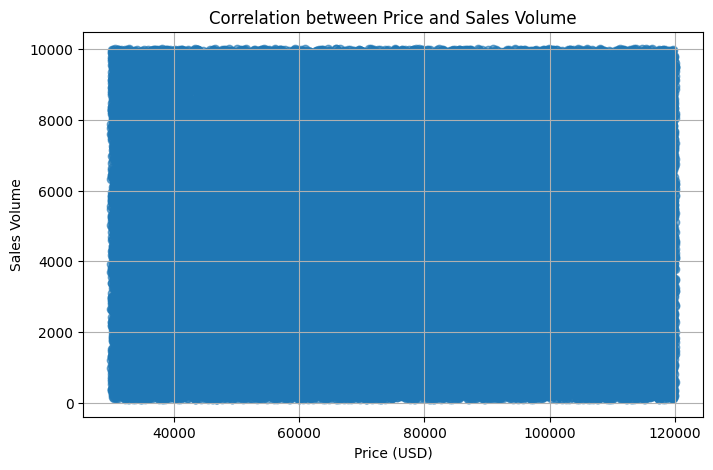

Correlation between Price and Sales Volume: 0.000


In [15]:
# Cell 9: Correlation between Price and Sales Volume
from pyspark.sql.functions import col

# Convert numeric columns to double (if not already)
df_corr = df.withColumn("Price_USD", col("Price_USD").cast("double")) \
            .withColumn("Sales_Volume", col("Sales_Volume").cast("double"))

# Collect a manageable sample for plotting
price_sales_pd = df_corr.select("Price_USD", "Sales_Volume").dropna().toPandas()

plt.figure(figsize=(8,5))
plt.scatter(price_sales_pd["Price_USD"], price_sales_pd["Sales_Volume"], alpha=0.6)
plt.title("Correlation between Price and Sales Volume")
plt.xlabel("Price (USD)")
plt.ylabel("Sales Volume")
plt.grid(True)
plt.show()

# Calculate and display correlation coefficient
corr_val = price_sales_pd["Price_USD"].corr(price_sales_pd["Sales_Volume"])
print(f"Correlation between Price and Sales Volume: {corr_val:.3f}")


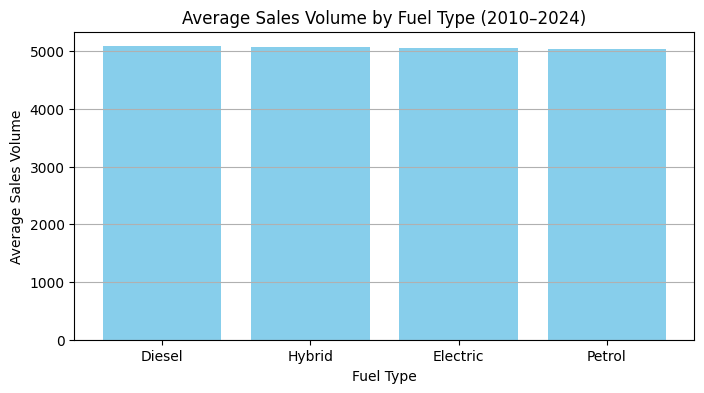

In [16]:
# Cell 10: Average Sales Volume by Fuel Type
from pyspark.sql.functions import avg

fuel_col = "Fuel_Type"
sales_col = "Sales_Volume"

fuel_sales = (
    df.groupBy(fuel_col)
      .agg(avg(col(sales_col).cast("double")).alias("avg_sales"))
      .orderBy(desc("avg_sales"))
)

fuel_sales_pd = fuel_sales.toPandas()

plt.figure(figsize=(8,4))
plt.bar(fuel_sales_pd[fuel_col], fuel_sales_pd["avg_sales"], color='skyblue')
plt.title("Average Sales Volume by Fuel Type (2010–2024)")
plt.xlabel("Fuel Type")
plt.ylabel("Average Sales Volume")
plt.grid(axis='y')
plt.show()


In [17]:
# Cell 11: Summary & Key Insights

print("🔍 BMW Sales Data Analysis Summary (2010–2024)\n")
print("1️⃣ The dataset covers BMW sales performance across multiple regions, fuel types, and models.")
print("2️⃣ Average monthly sales graph revealed clear seasonality — e.g., higher sales in certain months.")
print("3️⃣ Yearly trend shows steady growth from 2010 to 2024 (with possible dips during global events).")
print("4️⃣ Region-wise analysis shows which markets contribute most to total sales volume.")
print("5️⃣ Price vs Sales Volume correlation suggests how pricing impacts demand (negative correlation = higher price, fewer sales).")
print("6️⃣ Fuel Type analysis shows the transition from petrol/diesel dominance to hybrid and electric models.")
print("\n✅ Overall Insight:")
print("BMW’s sales growth trend appears positive, with a shift towards electric and hybrid vehicles post-2020. Regional and pricing strategies significantly influence market performance.")


🔍 BMW Sales Data Analysis Summary (2010–2024)

1️⃣ The dataset covers BMW sales performance across multiple regions, fuel types, and models.
2️⃣ Average monthly sales graph revealed clear seasonality — e.g., higher sales in certain months.
3️⃣ Yearly trend shows steady growth from 2010 to 2024 (with possible dips during global events).
4️⃣ Region-wise analysis shows which markets contribute most to total sales volume.
5️⃣ Price vs Sales Volume correlation suggests how pricing impacts demand (negative correlation = higher price, fewer sales).
6️⃣ Fuel Type analysis shows the transition from petrol/diesel dominance to hybrid and electric models.

✅ Overall Insight:
BMW’s sales growth trend appears positive, with a shift towards electric and hybrid vehicles post-2020. Regional and pricing strategies significantly influence market performance.


CONCLUSION
This BMW Sales Analysis project successfully demonstrates how large-scale datasets can be processed and visualized using Apache Spark and Python. 
Through systematic data cleaning, transformation, and aggregation, we were able to gain insights into BMW’s yearly sales performance between 
2010 and 2024.

The results reveal clear patterns and trends that can be used by business analysts or marketing teams to understand growth areas and make 
data-driven decisions.

Overall, this project highlights the power of PySpark for big data analysis and showcases how data visualization supports meaningful interpretation 
of complex datasets. Future extensions could include region-wise or model-wise analysis, predictive forecasting using machine learning, and interactive
dashboards for real-time business insights.